In [370]:
# !pip install tensorflow

In [371]:
#import librabries
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from datetime import datetime
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [372]:
risk_purchase_data = pd.read_csv('/content/risk-dataset.txt', delimiter="\t")

In [373]:
risk_purchase_data.head()

,ORDER_ID,CLASS,B_EMAIL,B_TELEFON,B_BIRTHDATE,FLAG_LRIDENTISCH,FLAG_NEWSLETTER,Z_METHODE,Z_CARD_ART,Z_CARD_VALID,...,FAIL_RPLZ,FAIL_RORT,FAIL_RPLZORTMATCH,SESSION_TIME,NEUKUNDE,AMOUNT_ORDER_PRE,VALUE_ORDER_PRE,DATE_LORDER,MAHN_AKT,MAHN_HOECHST
0,49917,no,yes,no,1/17/1973,yes,yes,check,?,5.2006,...,no,no,no,8,yes,0,0.00,?,?,?
1,49919,no,yes,yes,12/8/1970,no,no,credit_card,Visa,12.2007,...,yes,no,no,13,yes,0,0.00,?,?,?
2,49923,no,yes,no,4/3/1972,yes,no,check,?,12.2007,...,no,no,no,3,yes,0,0.00,?,?,?
3,49924,no,no,yes,8/1/1966,yes,no,check,?,1.2007,...,no,no,no,11,no,4,75.72,5/12/2002,0,0
4,49927,no,yes,yes,12/21/1969,yes,no,credit_card,Eurocard,12.2006,...,no,no,no,16,yes,0,0.00,?,?,?


In [374]:
risk_purchase_data.columns

Index(['ORDER_ID', 'CLASS', 'B_EMAIL', 'B_TELEFON', 'B_BIRTHDATE',
       'FLAG_LRIDENTISCH', 'FLAG_NEWSLETTER', 'Z_METHODE', 'Z_CARD_ART',
       'Z_CARD_VALID', 'Z_LAST_NAME', 'VALUE_ORDER', 'WEEKDAY_ORDER',
       'TIME_ORDER', 'AMOUNT_ORDER', 'ANUMMER_01', 'ANUMMER_02', 'ANUMMER_03',
       'ANUMMER_04', 'ANUMMER_05', 'ANUMMER_06', 'ANUMMER_07', 'ANUMMER_08',
       'ANUMMER_09', 'ANUMMER_10', 'CHK_LADR', 'CHK_RADR', 'CHK_KTO',
       'CHK_CARD', 'CHK_COOKIE', 'CHK_IP', 'FAIL_LPLZ', 'FAIL_LORT',
       'FAIL_LPLZORTMATCH', 'FAIL_RPLZ', 'FAIL_RORT', 'FAIL_RPLZORTMATCH',
       'SESSION_TIME', 'NEUKUNDE', 'AMOUNT_ORDER_PRE', 'VALUE_ORDER_PRE',
       'DATE_LORDER', 'MAHN_AKT', 'MAHN_HOECHST'],
      dtype='object')

In [375]:
risk_purchase_data.shape

(30000, 44)

In [376]:
risk_purchase_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 44 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ORDER_ID           30000 non-null  int64  
 1   CLASS              30000 non-null  object 
 2   B_EMAIL            30000 non-null  object 
 3   B_TELEFON          30000 non-null  object 
 4   B_BIRTHDATE        30000 non-null  object 
 5   FLAG_LRIDENTISCH   30000 non-null  object 
 6   FLAG_NEWSLETTER    30000 non-null  object 
 7   Z_METHODE          30000 non-null  object 
 8   Z_CARD_ART         30000 non-null  object 
 9   Z_CARD_VALID       30000 non-null  float64
 10  Z_LAST_NAME        30000 non-null  object 
 11  VALUE_ORDER        30000 non-null  float64
 12  WEEKDAY_ORDER      30000 non-null  object 
 13  TIME_ORDER         30000 non-null  object 
 14  AMOUNT_ORDER       30000 non-null  int64  
 15  ANUMMER_01         30000 non-null  int64  
 16  ANUMMER_02         300

In [377]:
risk_purchase_data.replace('?', np.nan, inplace=True)

<ipython-input-377-4f8e6bd467b4>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  risk_purchase_data.replace('?', np.nan, inplace=True)


In [378]:
risk_purchase_data.isnull().sum()


,0
ORDER_ID,0
CLASS,0
B_EMAIL,0
B_TELEFON,0
B_BIRTHDATE,2942
FLAG_LRIDENTISCH,0
FLAG_NEWSLETTER,0
Z_METHODE,0
Z_CARD_ART,18654
Z_CARD_VALID,0


In [379]:
def calculate_age(birthdate):
    if pd.isnull(birthdate):
        return 0
    today = datetime.today()
    return today.year - birthdate.year - ((today.month, today.day) < (birthdate.month, birthdate.day))

risk_purchase_data['B_BIRTHDATE'] = pd.to_datetime(risk_purchase_data['B_BIRTHDATE'], errors='coerce')

risk_purchase_data['Age'] = risk_purchase_data['B_BIRTHDATE'].apply(calculate_age)

In [380]:
columns_to_fill_zero = ['ANUMMER_01', 'ANUMMER_02', 'ANUMMER_03', 'ANUMMER_04',
                   'ANUMMER_05', 'ANUMMER_06', 'ANUMMER_07', 'ANUMMER_08',
                   'ANUMMER_09', 'ANUMMER_10','MAHN_AKT','MAHN_HOECHST']

risk_purchase_data[columns_to_fill_zero] = risk_purchase_data[columns_to_fill_zero].fillna(0)

In [381]:
risk_purchase_data['DATE_LORDER'] = pd.to_datetime(risk_purchase_data['DATE_LORDER'], errors='coerce')

current_date = datetime.today()

risk_purchase_data['days_since_last_order'] = risk_purchase_data['DATE_LORDER'].apply(
    lambda x: (current_date - x).days if pd.notna(x) else np.nan
)

In [382]:
risk_purchase_data['days_since_last_order'].describe()

,days_since_last_order
count,14144.000000
mean,8119.665936
std,435.065889
min,7369.000000
25%,7741.000000
50%,8115.000000
75%,8499.000000
max,8868.000000


In [383]:
risk_purchase_data['Recency_Category'] = pd.cut(risk_purchase_data['days_since_last_order'],
                                                bins=[7000, 7500, 8000, 8500, 9000, float('inf')],
                                                labels=['New', 'Active', 'Lapsed', 'Churned', 'Long Gone'])
risk_purchase_data['Recency_Category'] = risk_purchase_data['Recency_Category'].cat.add_categories('Unknown')

In [384]:
columns_to_fill_unknown = ['Z_CARD_ART','Z_METHODE', 'Z_LAST_NAME','TIME_ORDER', 'Recency_Category' ]
risk_purchase_data[columns_to_fill_unknown] = risk_purchase_data[columns_to_fill_unknown].fillna('Unknown')

In [385]:
def categorize_time_order(time):
    if time:
        return 'Unknown'
    if time >= pd.to_datetime('00:00:00', format='%H:%M').time() and time < pd.to_datetime('06:00:00', format='%H:%M').time():
        return 'Early Morning'
    elif time >= pd.to_datetime('06:00:00', format='%H:%M').time() and time < pd.to_datetime('12:00:00', format='%H:%M').time():
        return 'Morning'
    elif time >= pd.to_datetime('12:00:00', format='%H:%M').time() and time < pd.to_datetime('17:00:00', format='%H:%M').time():
        return 'Afternoon'
    elif time >= pd.to_datetime('17:00:00', format='%H:%M').time() and time < pd.to_datetime('22:00:00', format='%H:%M').time():
        return 'Evening'
    else:
        return 'Late Night'

risk_purchase_data['TIME_ORDER'] = risk_purchase_data['TIME_ORDER'].apply(lambda x: pd.to_datetime(x, format='%H:%M').time() if x != 'Unknown' else x)

risk_purchase_data['Time_Order_Category'] = risk_purchase_data['TIME_ORDER'].apply(categorize_time_order)


In [386]:
risk_purchase_data['Z_CARD_VALID'].unique()

array([ 5.2006, 12.2007,  1.2007, 12.2006,  2.2007, 11.2007,  5.2005,
        9.2007, 11.2006,  2.2006,  6.2006,  3.2007,  6.2005,  6.2007,
        3.2005,  4.2005, 11.2005,  4.2006,  3.2006,  9.2006, 12.2005,
        8.2007, 10.2006,  2.2005,  7.2007, 10.2005,  7.2005,  8.2005,
        9.2005,  7.2006,  1.2006,  1.2005,  8.2006, 10.2007,  4.2007,
        5.2007])

In [387]:
risk_purchase_data['Z_CARD_VALID'] = pd.to_datetime(risk_purchase_data['Z_CARD_VALID'], format='%m.%Y', errors='coerce')
current_date = pd.to_datetime('today')
risk_purchase_data['Z_CARD_VALID'] = (risk_purchase_data['Z_CARD_VALID'] < current_date).astype(int)

In [388]:
yes_no_cols = ['B_EMAIL', 'B_TELEFON', 'FLAG_LRIDENTISCH', 'FLAG_NEWSLETTER', 'CHK_LADR',
               'CHK_RADR', 'CHK_KTO', 'CHK_CARD', 'CHK_COOKIE', 'CHK_IP', 'FAIL_LPLZ',
               'FAIL_LORT', 'FAIL_LPLZORTMATCH', 'FAIL_RPLZ', 'FAIL_RORT', 'FAIL_RPLZORTMATCH', 'NEUKUNDE']
for col in yes_no_cols:
    risk_purchase_data[col] = risk_purchase_data[col].map({'yes': 1, 'no': 0})

In [389]:
columns_to_convert = ['ANUMMER_02', 'ANUMMER_03', 'ANUMMER_04', 'ANUMMER_05', 'ANUMMER_06',
                      'ANUMMER_07', 'ANUMMER_08', 'ANUMMER_09', 'ANUMMER_10','MAHN_AKT','MAHN_HOECHST']
for col in columns_to_convert:
  risk_purchase_data[col] = pd.to_numeric(risk_purchase_data[col], errors='coerce')

In [390]:
risk_purchase_data['ANUMMER_10'].unique()

array([0.])

In [391]:
risk_purchase_data.drop(['ORDER_ID','B_BIRTHDATE','DATE_LORDER','days_since_last_order','TIME_ORDER','ANUMMER_10'], axis=1, inplace=True)

In [392]:
risk_purchase_data.isnull().sum()

,0
CLASS,0
B_EMAIL,0
B_TELEFON,0
FLAG_LRIDENTISCH,0
FLAG_NEWSLETTER,0
Z_METHODE,0
Z_CARD_ART,0
Z_CARD_VALID,0
Z_LAST_NAME,0
VALUE_ORDER,0


In [393]:
X = risk_purchase_data.drop(columns=["CLASS"])
y = risk_purchase_data["CLASS"]

In [394]:
y = LabelEncoder().fit_transform(y)

In [395]:
X['WEEKDAY_ORDER'] = LabelEncoder().fit_transform(X['WEEKDAY_ORDER'])

In [396]:
object_category_columns = X.select_dtypes(include=['object', 'category']).columns
X = pd.get_dummies(X, columns=object_category_columns, drop_first=True).astype(int)

In [397]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 50 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   B_EMAIL                     30000 non-null  int64
 1   B_TELEFON                   30000 non-null  int64
 2   FLAG_LRIDENTISCH            30000 non-null  int64
 3   FLAG_NEWSLETTER             30000 non-null  int64
 4   Z_CARD_VALID                30000 non-null  int64
 5   VALUE_ORDER                 30000 non-null  int64
 6   WEEKDAY_ORDER               30000 non-null  int64
 7   AMOUNT_ORDER                30000 non-null  int64
 8   ANUMMER_01                  30000 non-null  int64
 9   ANUMMER_02                  30000 non-null  int64
 10  ANUMMER_03                  30000 non-null  int64
 11  ANUMMER_04                  30000 non-null  int64
 12  ANUMMER_05                  30000 non-null  int64
 13  ANUMMER_06                  30000 non-null  int64
 14  ANUMME

In [398]:
X.head()

,B_EMAIL,B_TELEFON,FLAG_LRIDENTISCH,FLAG_NEWSLETTER,Z_CARD_VALID,VALUE_ORDER,WEEKDAY_ORDER,AMOUNT_ORDER,ANUMMER_01,ANUMMER_02,...,Z_CARD_ART_Unknown,Z_CARD_ART_Visa,Z_CARD_ART_debit_card,Z_LAST_NAME_no,Z_LAST_NAME_yes,Recency_Category_Active,Recency_Category_Lapsed,Recency_Category_Churned,Recency_Category_Long Gone,Recency_Category_Unknown
0,1,0,1,1,0,17,2,1,406811,0,...,1,0,0,0,0,0,0,0,0,1
1,1,1,0,0,0,18,6,1,600953,0,...,0,1,0,0,1,0,0,0,0,1
2,1,0,1,0,0,10,0,1,406310,0,...,1,0,0,0,0,0,0,0,0,1
3,0,1,1,0,0,54,0,1,307359,0,...,1,0,0,0,0,0,1,0,0,0
4,1,1,1,0,0,19,5,1,200767,0,...,0,0,0,0,1,0,0,0,0,1


In [399]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [400]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [401]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [402]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("Class Weights:", class_weight_dict)

Class Weights: {0: np.float64(1.0), 1: np.float64(1.0)}


In [403]:
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [404]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [405]:
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [406]:
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_test, y_test), class_weight=class_weight_dict)

Epoch 1/25
1412/1412 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6506 - loss: 0.6306 - val_accuracy: 0.7037 - val_loss: 0.5904
Epoch 2/25
1412/1412 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7202 - loss: 0.5560 - val_accuracy: 0.7008 - val_loss: 0.5596
Epoch 3/25
1412/1412 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7371 - loss: 0.5268 - val_accuracy: 0.7023 - val_loss: 0.5525
Epoch 4/25
1412/1412 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7505 - loss: 0.5090 - val_accuracy: 0.7335 - val_loss: 0.5260
Epoch 5/25
1412/1412 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7658 - loss: 0.4884 - val_accuracy: 0.7308 - val_loss: 0.5169
Epoch 6/25
1412/1412 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7710 - loss: 0.4763 - val_accuracy: 0.7475 - val_loss: 0.4836
Epoch 7/25
1412/1412 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7794 - loss: 0.4647 - val_accuracy: 0.7235 - val_loss: 0.5254
Epoch 8/25
1412/1412 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7814 - loss: 0.4571 - 

In [407]:
loss, accuracy = model.evaluate(X_train, y_train)
print(f"Test Accuracy: {accuracy:.4f}")

1412/1412 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8254 - loss: 0.3328
Test Accuracy: 0.8677


In [408]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7659 - loss: 0.4648
Test Accuracy: 0.7712


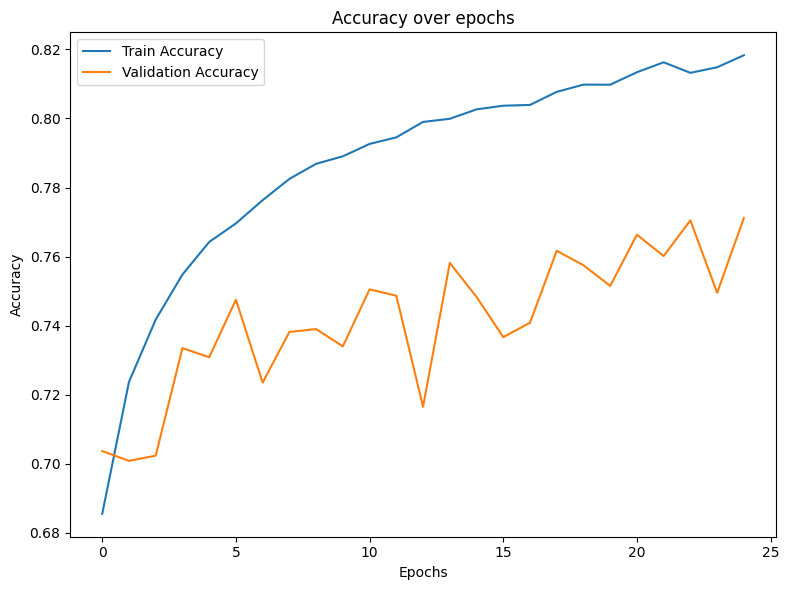

In [409]:
# Plot training & validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

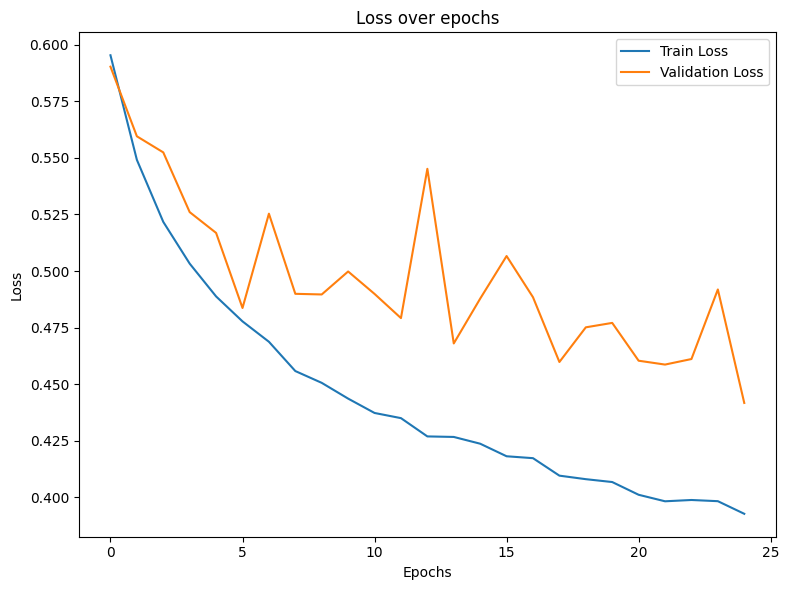

In [410]:
# Plot training & validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()